In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        folds=10,
                        random_state=42
                       )

In [6]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000
mean,72.507501,45.017416,37.385395,32.282586,29.288099,29.037299,28.624832,28.652316,28.255287,27.680432,...,-0.019696,-0.020280,14.121078,25.642969,5.110945,22.803641,4.728321,0.64000,24.500000,5.500
std,22.429185,13.749270,13.990447,12.482451,12.844946,13.193927,13.244052,13.745964,13.744182,13.444088,...,0.089549,0.087767,17.305620,21.175693,8.236620,11.064539,2.151362,0.48012,14.434479,2.873
min,0.467220,0.753611,1.282752,1.074155,0.907809,1.276880,0.428470,0.633548,0.846962,0.617773,...,-0.519763,-0.484627,4.764953,11.652139,1.998343,7.152852,0.541668,0.00000,0.000000,1.000
25%,56.616318,35.282913,26.778110,21.631800,17.349314,16.378429,15.822052,14.926780,14.737826,13.820180,...,-0.071463,-0.073589,10.407418,19.937195,3.772418,17.130730,3.134890,0.00000,12.000000,3.000
50%,72.159225,44.696267,35.244943,31.169037,29.073932,28.958849,29.090751,29.458454,29.727010,29.389315,...,-0.014375,-0.014034,12.773370,23.508346,4.645349,20.725994,4.524411,1.00000,24.500000,5.500
75%,87.413906,54.137569,46.248867,41.829136,39.997071,40.208394,39.942740,39.787000,39.563445,39.231914,...,0.034963,0.034582,15.856162,28.285405,5.564719,25.669332,6.069126,1.00000,37.000000,8.000
max,199.820669,106.418461,91.874706,75.098603,72.087316,74.091721,83.406522,92.924575,103.945276,102.208297,...,0.456353,0.419580,753.679121,897.018995,361.159924,337.308704,17.336297,1.00000,49.000000,10.000


In [7]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [8]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['target']

# Deep Net
Separate into classes

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

In [10]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(30,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [11]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
feat_red = PCA(n_components=30)
feat_red.fit(train_X,y=train_y)
train_X = feat_red.transform(train_X)

clf = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=1000, 
                       batch_size=256, 
                       validation_split=0.15)

history = clf.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1984      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

1224/1224 [==============================] - 0s 31us/step - loss: 3.0323 - acc: 0.1209 - val_loss: 3.1135 - val_acc: 0.0880
Epoch 49/1000
1224/1224 [==============================] - 0s 31us/step - loss: 3.0632 - acc: 0.1119 - val_loss: 3.1123 - val_acc: 0.0926
Epoch 50/1000
1224/1224 [==============================] - 0s 31us/step - loss: 3.0665 - acc: 0.1087 - val_loss: 3.1031 - val_acc: 0.0972
Epoch 51/1000
1224/1224 [==============================] - 0s 32us/step - loss: 3.0388 - acc: 0.1413 - val_loss: 3.0994 - val_acc: 0.1157
Epoch 52/1000
1224/1224 [==============================] - 0s 34us/step - loss: 3.0155 - acc: 0.1266 - val_loss: 3.1077 - val_acc: 0.1296
Epoch 53/1000
1224/1224 [==============================] - 0s 34us/step - loss: 3.0349 - acc: 0.1258 - val_loss: 3.0967 - val_acc: 0.1019
Epoch 54/1000
1224/1224 [==============================] - 0s 31us/step - loss: 3.0510 - acc: 0.1234 - val_loss: 3.0900 - val_acc: 0.1019
Epoch 55/1000
1224/1224 [=======================

1224/1224 [==============================] - 0s 29us/step - loss: 2.7581 - acc: 0.1683 - val_loss: 2.9648 - val_acc: 0.1713
Epoch 108/1000
1224/1224 [==============================] - 0s 30us/step - loss: 2.6421 - acc: 0.1928 - val_loss: 2.9889 - val_acc: 0.1759
Epoch 109/1000
1224/1224 [==============================] - 0s 30us/step - loss: 2.7315 - acc: 0.1757 - val_loss: 2.9745 - val_acc: 0.1759
Epoch 110/1000
1224/1224 [==============================] - 0s 27us/step - loss: 2.6868 - acc: 0.1969 - val_loss: 2.9631 - val_acc: 0.1898
Epoch 111/1000
1224/1224 [==============================] - 0s 29us/step - loss: 2.6649 - acc: 0.1936 - val_loss: 2.9639 - val_acc: 0.1852
Epoch 112/1000
1224/1224 [==============================] - 0s 31us/step - loss: 2.6733 - acc: 0.1846 - val_loss: 2.9572 - val_acc: 0.1898
Epoch 113/1000
1224/1224 [==============================] - 0s 29us/step - loss: 2.6832 - acc: 0.1691 - val_loss: 2.9512 - val_acc: 0.1852
Epoch 114/1000
1224/1224 [================

1224/1224 [==============================] - 0s 29us/step - loss: 2.4564 - acc: 0.2467 - val_loss: 2.9483 - val_acc: 0.1898
Epoch 167/1000
1224/1224 [==============================] - 0s 30us/step - loss: 2.4037 - acc: 0.2639 - val_loss: 2.9567 - val_acc: 0.1898
Epoch 168/1000
1224/1224 [==============================] - 0s 29us/step - loss: 2.4441 - acc: 0.2418 - val_loss: 2.9542 - val_acc: 0.1667
Epoch 169/1000
1224/1224 [==============================] - 0s 29us/step - loss: 2.4087 - acc: 0.2598 - val_loss: 2.9435 - val_acc: 0.1944
Epoch 170/1000
1224/1224 [==============================] - 0s 29us/step - loss: 2.4218 - acc: 0.2655 - val_loss: 2.9527 - val_acc: 0.1944
Epoch 171/1000
1224/1224 [==============================] - 0s 30us/step - loss: 2.4476 - acc: 0.2418 - val_loss: 2.9214 - val_acc: 0.2222
Epoch 172/1000
1224/1224 [==============================] - 0s 29us/step - loss: 2.4099 - acc: 0.2328 - val_loss: 2.9253 - val_acc: 0.1991
Epoch 173/1000
1224/1224 [================

1224/1224 [==============================] - 0s 30us/step - loss: 2.2598 - acc: 0.2835 - val_loss: 2.9393 - val_acc: 0.2222
Epoch 226/1000
1224/1224 [==============================] - 0s 30us/step - loss: 2.2602 - acc: 0.2982 - val_loss: 2.9586 - val_acc: 0.2176
Epoch 227/1000
1224/1224 [==============================] - 0s 28us/step - loss: 2.2746 - acc: 0.2819 - val_loss: 2.9378 - val_acc: 0.2222
Epoch 228/1000
1224/1224 [==============================] - 0s 28us/step - loss: 2.2266 - acc: 0.3121 - val_loss: 2.9594 - val_acc: 0.2315
Epoch 229/1000
1224/1224 [==============================] - 0s 27us/step - loss: 2.2527 - acc: 0.3039 - val_loss: 2.9430 - val_acc: 0.2315
Epoch 230/1000
1224/1224 [==============================] - 0s 28us/step - loss: 2.2250 - acc: 0.3015 - val_loss: 2.9731 - val_acc: 0.2130
Epoch 231/1000
1224/1224 [==============================] - 0s 30us/step - loss: 2.1763 - acc: 0.3039 - val_loss: 2.9684 - val_acc: 0.2083
Epoch 232/1000
1224/1224 [================

1224/1224 [==============================] - 0s 32us/step - loss: 2.0776 - acc: 0.3407 - val_loss: 3.0326 - val_acc: 0.2546
Epoch 285/1000
1224/1224 [==============================] - 0s 29us/step - loss: 2.0829 - acc: 0.3489 - val_loss: 2.9956 - val_acc: 0.2500
Epoch 286/1000
1224/1224 [==============================] - 0s 30us/step - loss: 2.0626 - acc: 0.3505 - val_loss: 2.9982 - val_acc: 0.2500
Epoch 287/1000
1224/1224 [==============================] - 0s 30us/step - loss: 2.0797 - acc: 0.3415 - val_loss: 2.9965 - val_acc: 0.2500
Epoch 288/1000
1224/1224 [==============================] - 0s 29us/step - loss: 2.0671 - acc: 0.3480 - val_loss: 3.0260 - val_acc: 0.2500
Epoch 289/1000
1224/1224 [==============================] - 0s 30us/step - loss: 2.0677 - acc: 0.3480 - val_loss: 3.0176 - val_acc: 0.2407
Epoch 290/1000
1224/1224 [==============================] - 0s 29us/step - loss: 2.0796 - acc: 0.3276 - val_loss: 3.0248 - val_acc: 0.2315
Epoch 291/1000
1224/1224 [================

1224/1224 [==============================] - 0s 29us/step - loss: 1.9653 - acc: 0.3791 - val_loss: 3.0324 - val_acc: 0.2546
Epoch 344/1000
1224/1224 [==============================] - 0s 29us/step - loss: 1.9235 - acc: 0.3807 - val_loss: 3.0287 - val_acc: 0.2685
Epoch 345/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.9543 - acc: 0.3856 - val_loss: 3.0300 - val_acc: 0.2500
Epoch 346/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.9508 - acc: 0.3766 - val_loss: 3.0653 - val_acc: 0.2593
Epoch 347/1000
1224/1224 [==============================] - 0s 29us/step - loss: 1.9169 - acc: 0.3930 - val_loss: 3.0485 - val_acc: 0.2639
Epoch 348/1000
1224/1224 [==============================] - 0s 29us/step - loss: 1.9294 - acc: 0.3979 - val_loss: 3.0488 - val_acc: 0.2639
Epoch 349/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.9250 - acc: 0.3807 - val_loss: 3.0458 - val_acc: 0.2917
Epoch 350/1000
1224/1224 [================

1224/1224 [==============================] - 0s 24us/step - loss: 1.8137 - acc: 0.4232 - val_loss: 3.1296 - val_acc: 0.2870
Epoch 403/1000
1224/1224 [==============================] - 0s 27us/step - loss: 1.8146 - acc: 0.4085 - val_loss: 3.1303 - val_acc: 0.2778
Epoch 404/1000
1224/1224 [==============================] - 0s 27us/step - loss: 1.8251 - acc: 0.4060 - val_loss: 3.1506 - val_acc: 0.2778
Epoch 405/1000
1224/1224 [==============================] - 0s 25us/step - loss: 1.8516 - acc: 0.4387 - val_loss: 3.1436 - val_acc: 0.2778
Epoch 406/1000
1224/1224 [==============================] - 0s 25us/step - loss: 1.8287 - acc: 0.4069 - val_loss: 3.1431 - val_acc: 0.2685
Epoch 407/1000
1224/1224 [==============================] - 0s 27us/step - loss: 1.8375 - acc: 0.4257 - val_loss: 3.1770 - val_acc: 0.2731
Epoch 408/1000
1224/1224 [==============================] - 0s 29us/step - loss: 1.8229 - acc: 0.4224 - val_loss: 3.1711 - val_acc: 0.2731
Epoch 409/1000
1224/1224 [================

1224/1224 [==============================] - 0s 31us/step - loss: 1.7019 - acc: 0.4363 - val_loss: 3.2147 - val_acc: 0.2685
Epoch 462/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.7575 - acc: 0.4461 - val_loss: 3.2006 - val_acc: 0.2685
Epoch 463/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.7476 - acc: 0.4534 - val_loss: 3.2024 - val_acc: 0.2685
Epoch 464/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.7543 - acc: 0.4167 - val_loss: 3.1825 - val_acc: 0.2546
Epoch 465/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.7280 - acc: 0.4346 - val_loss: 3.1978 - val_acc: 0.2778
Epoch 466/1000
1224/1224 [==============================] - 0s 29us/step - loss: 1.7142 - acc: 0.4428 - val_loss: 3.2184 - val_acc: 0.2685
Epoch 467/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.7781 - acc: 0.4395 - val_loss: 3.2036 - val_acc: 0.2593
Epoch 468/1000
1224/1224 [================

1224/1224 [==============================] - 0s 33us/step - loss: 1.6565 - acc: 0.4681 - val_loss: 3.2588 - val_acc: 0.2593
Epoch 521/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.6649 - acc: 0.4641 - val_loss: 3.2513 - val_acc: 0.2593
Epoch 522/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.6545 - acc: 0.4575 - val_loss: 3.2750 - val_acc: 0.2685
Epoch 523/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.6634 - acc: 0.4739 - val_loss: 3.2865 - val_acc: 0.2778
Epoch 524/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.6772 - acc: 0.4730 - val_loss: 3.2869 - val_acc: 0.2824
Epoch 525/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.6437 - acc: 0.4788 - val_loss: 3.3012 - val_acc: 0.2824
Epoch 526/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.6296 - acc: 0.4812 - val_loss: 3.3246 - val_acc: 0.2731
Epoch 527/1000
1224/1224 [================

1224/1224 [==============================] - 0s 30us/step - loss: 1.5881 - acc: 0.4918 - val_loss: 3.3548 - val_acc: 0.2500
Epoch 580/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.6025 - acc: 0.4804 - val_loss: 3.3419 - val_acc: 0.2593
Epoch 581/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.6441 - acc: 0.4624 - val_loss: 3.3255 - val_acc: 0.2593
Epoch 582/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.6492 - acc: 0.4722 - val_loss: 3.2759 - val_acc: 0.2593
Epoch 583/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.5988 - acc: 0.4763 - val_loss: 3.3313 - val_acc: 0.2639
Epoch 584/1000
1224/1224 [==============================] - 0s 29us/step - loss: 1.6511 - acc: 0.4477 - val_loss: 3.3025 - val_acc: 0.2778
Epoch 585/1000
1224/1224 [==============================] - 0s 29us/step - loss: 1.5967 - acc: 0.4886 - val_loss: 3.3244 - val_acc: 0.2454
Epoch 586/1000
1224/1224 [================

1224/1224 [==============================] - 0s 32us/step - loss: 1.5380 - acc: 0.5098 - val_loss: 3.4142 - val_acc: 0.2593
Epoch 639/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.5487 - acc: 0.5016 - val_loss: 3.4335 - val_acc: 0.2593
Epoch 640/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.5026 - acc: 0.5155 - val_loss: 3.4390 - val_acc: 0.2500
Epoch 641/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.4870 - acc: 0.5123 - val_loss: 3.4943 - val_acc: 0.2500
Epoch 642/1000
1224/1224 [==============================] - 0s 34us/step - loss: 1.5312 - acc: 0.4943 - val_loss: 3.4751 - val_acc: 0.2454
Epoch 643/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.5228 - acc: 0.4984 - val_loss: 3.4379 - val_acc: 0.2593
Epoch 644/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.5401 - acc: 0.4910 - val_loss: 3.4453 - val_acc: 0.2639
Epoch 645/1000
1224/1224 [================

1224/1224 [==============================] - 0s 33us/step - loss: 1.5080 - acc: 0.5041 - val_loss: 3.3960 - val_acc: 0.2546
Epoch 698/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.4262 - acc: 0.5359 - val_loss: 3.4648 - val_acc: 0.2407
Epoch 699/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.4863 - acc: 0.5114 - val_loss: 3.4722 - val_acc: 0.2546
Epoch 700/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.5036 - acc: 0.5196 - val_loss: 3.4561 - val_acc: 0.2361
Epoch 701/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.4730 - acc: 0.5261 - val_loss: 3.4424 - val_acc: 0.2500
Epoch 702/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.4259 - acc: 0.5229 - val_loss: 3.4557 - val_acc: 0.2407
Epoch 703/1000
1224/1224 [==============================] - 0s 34us/step - loss: 1.4493 - acc: 0.5335 - val_loss: 3.4544 - val_acc: 0.2500
Epoch 704/1000
1224/1224 [================

1224/1224 [==============================] - 0s 40us/step - loss: 1.4011 - acc: 0.5359 - val_loss: 3.5316 - val_acc: 0.2639
Epoch 757/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.4734 - acc: 0.5172 - val_loss: 3.4969 - val_acc: 0.2593
Epoch 758/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.4350 - acc: 0.5482 - val_loss: 3.5215 - val_acc: 0.2546
Epoch 759/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.3979 - acc: 0.5531 - val_loss: 3.4857 - val_acc: 0.2593
Epoch 760/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.4122 - acc: 0.5359 - val_loss: 3.5012 - val_acc: 0.2731
Epoch 761/1000
1224/1224 [==============================] - 0s 34us/step - loss: 1.4564 - acc: 0.5302 - val_loss: 3.5405 - val_acc: 0.2685
Epoch 762/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.4386 - acc: 0.5196 - val_loss: 3.5369 - val_acc: 0.2500
Epoch 763/1000
1224/1224 [================

1224/1224 [==============================] - 0s 32us/step - loss: 1.3858 - acc: 0.5727 - val_loss: 3.5393 - val_acc: 0.2546
Epoch 816/1000
1224/1224 [==============================] - 0s 34us/step - loss: 1.3756 - acc: 0.5613 - val_loss: 3.5599 - val_acc: 0.2500
Epoch 817/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.3529 - acc: 0.5678 - val_loss: 3.5853 - val_acc: 0.2593
Epoch 818/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.4283 - acc: 0.5547 - val_loss: 3.5840 - val_acc: 0.2546
Epoch 819/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.3843 - acc: 0.5547 - val_loss: 3.5804 - val_acc: 0.2593
Epoch 820/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.3736 - acc: 0.5515 - val_loss: 3.5721 - val_acc: 0.2593
Epoch 821/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.3560 - acc: 0.5711 - val_loss: 3.5589 - val_acc: 0.2639
Epoch 822/1000
1224/1224 [================

1224/1224 [==============================] - 0s 32us/step - loss: 1.2774 - acc: 0.5776 - val_loss: 3.6712 - val_acc: 0.2500
Epoch 875/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.3861 - acc: 0.5458 - val_loss: 3.6320 - val_acc: 0.2546
Epoch 876/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.3369 - acc: 0.5621 - val_loss: 3.6474 - val_acc: 0.2546
Epoch 877/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.3615 - acc: 0.5703 - val_loss: 3.6177 - val_acc: 0.2546
Epoch 878/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.3250 - acc: 0.5645 - val_loss: 3.6489 - val_acc: 0.2500
Epoch 879/1000
1224/1224 [==============================] - 0s 29us/step - loss: 1.3946 - acc: 0.5580 - val_loss: 3.6832 - val_acc: 0.2546
Epoch 880/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.3459 - acc: 0.5580 - val_loss: 3.6683 - val_acc: 0.2500
Epoch 881/1000
1224/1224 [================

1224/1224 [==============================] - 0s 33us/step - loss: 1.2706 - acc: 0.5825 - val_loss: 3.6443 - val_acc: 0.2454
Epoch 934/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.3084 - acc: 0.5792 - val_loss: 3.6209 - val_acc: 0.2361
Epoch 935/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.3336 - acc: 0.5776 - val_loss: 3.6928 - val_acc: 0.2361
Epoch 936/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.3588 - acc: 0.5580 - val_loss: 3.6680 - val_acc: 0.2407
Epoch 937/1000
1224/1224 [==============================] - 0s 31us/step - loss: 1.3195 - acc: 0.5850 - val_loss: 3.6304 - val_acc: 0.2500
Epoch 938/1000
1224/1224 [==============================] - 0s 30us/step - loss: 1.3195 - acc: 0.5850 - val_loss: 3.6336 - val_acc: 0.2500
Epoch 939/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.2295 - acc: 0.5948 - val_loss: 3.6778 - val_acc: 0.2639
Epoch 940/1000
1224/1224 [================

1224/1224 [==============================] - 0s 33us/step - loss: 1.3094 - acc: 0.5727 - val_loss: 3.7268 - val_acc: 0.2639
Epoch 993/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.3187 - acc: 0.5833 - val_loss: 3.7225 - val_acc: 0.2500
Epoch 994/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.3338 - acc: 0.5833 - val_loss: 3.7046 - val_acc: 0.2593
Epoch 995/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.2373 - acc: 0.5915 - val_loss: 3.6951 - val_acc: 0.2639
Epoch 996/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.2596 - acc: 0.5940 - val_loss: 3.7260 - val_acc: 0.2639
Epoch 997/1000
1224/1224 [==============================] - 0s 32us/step - loss: 1.3127 - acc: 0.5760 - val_loss: 3.7315 - val_acc: 0.2731
Epoch 998/1000
1224/1224 [==============================] - 0s 33us/step - loss: 1.3171 - acc: 0.5703 - val_loss: 3.7096 - val_acc: 0.2593
Epoch 999/1000
1224/1224 [================

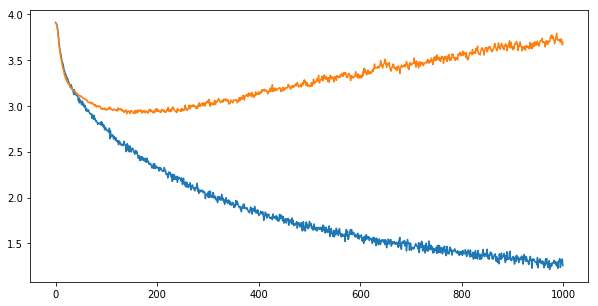

In [12]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

0.12777777777777777
Confusion matrix, without normalization
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 4]]


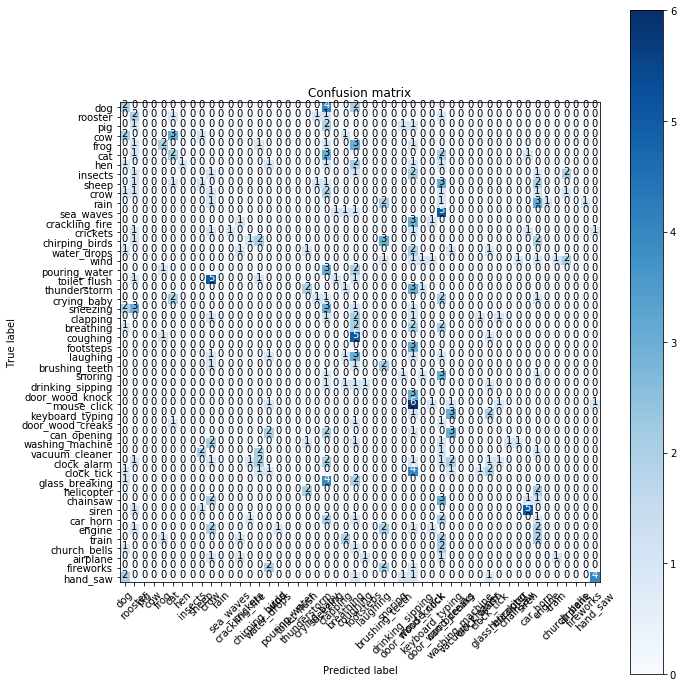

In [13]:
test_X = scaler.fit_transform(test_X)
test_X = feat_red.transform(test_X)

pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

# All Data

In [14]:
all_df = df[df.fold == 1]

In [15]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['target']
X = scaler.fit_transform(X)
X = feat_red.transform(X)

0.12
Confusion matrix, without normalization
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 ...
 [0 2 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]]


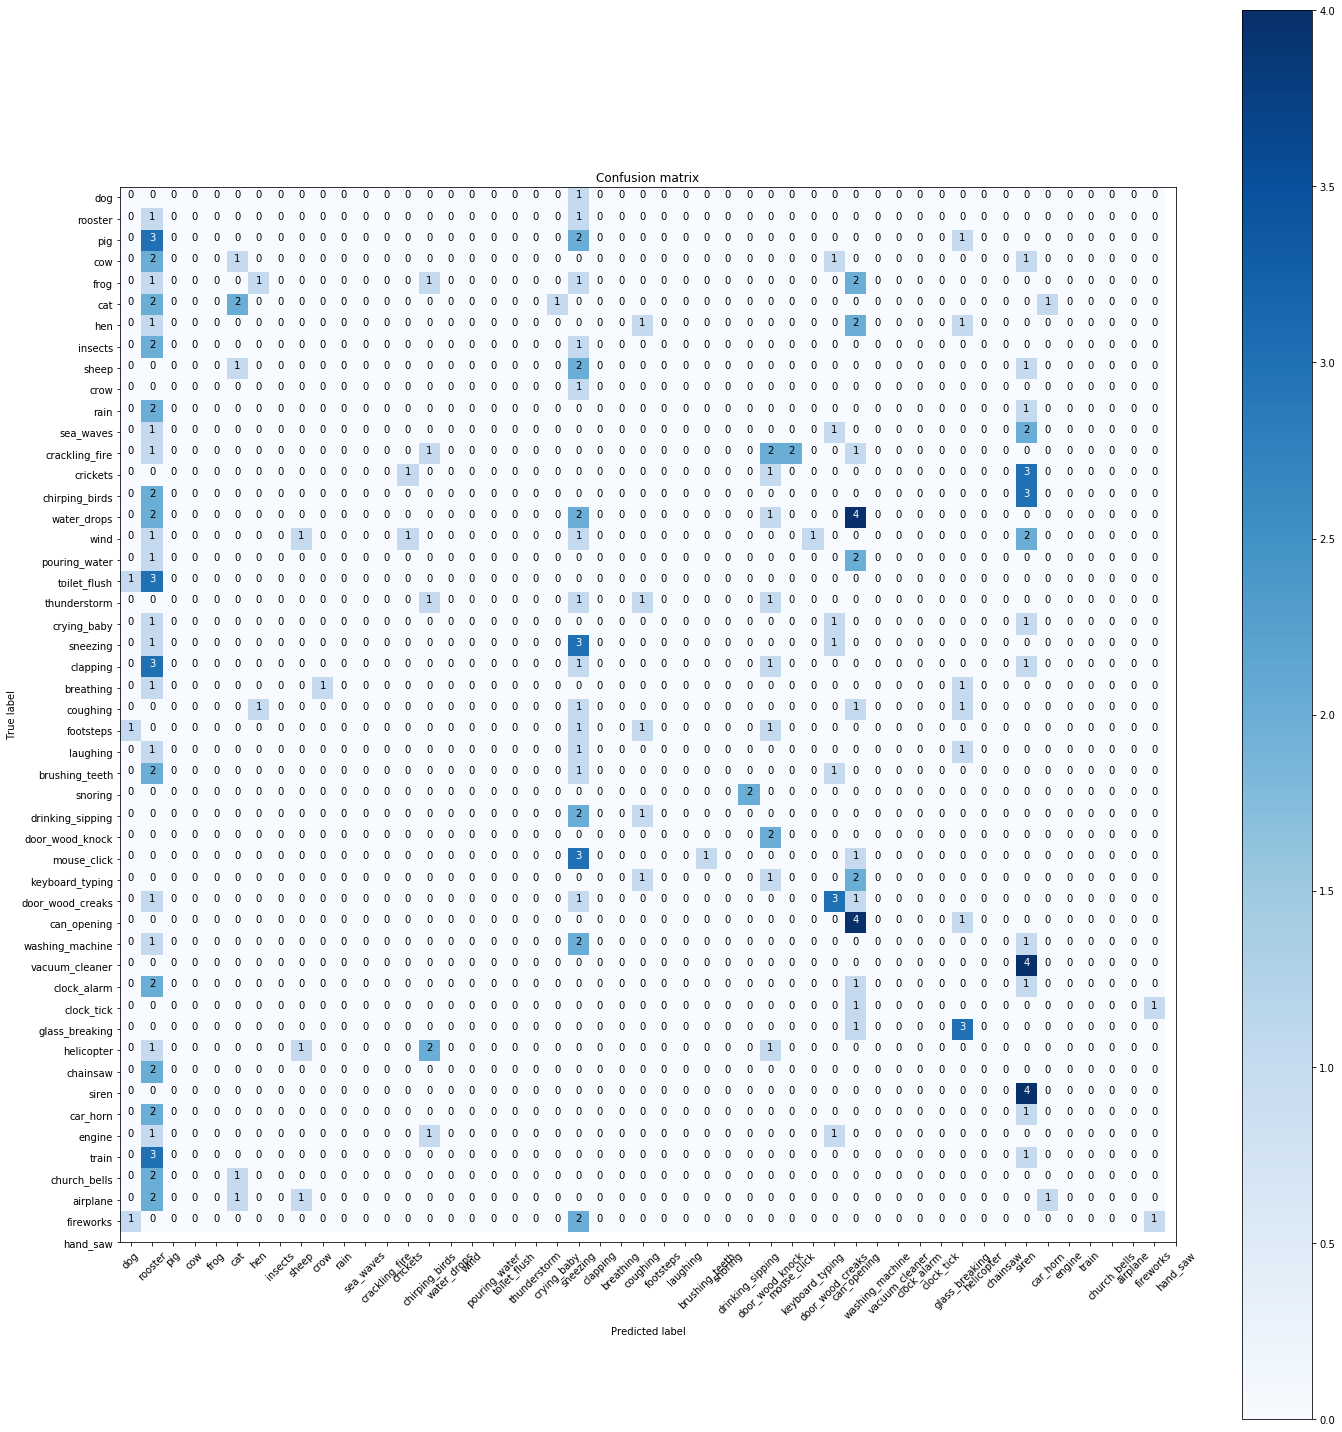

In [16]:
pred = clf.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()